In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
import cv2

In [2]:
images=np.load('images.npy')
images_gt=np.load('images_gt.npy',allow_pickle=True)
labels=np.load('labels.npy')

def generate_density(x,y,sig):
    dense=np.zeros([640,480])
    for i in range(len(x)):
        dense[int(x[i]),int(y[i])]=1000
    dense=gaussian_filter(dense,sigma=(sig,sig),order=0).T    
    return dense

images_density=np.zeros([images.shape[0],480,640])
for i in range(images.shape[0]):
    images_density[i]=generate_density(images_gt[i][:,0],images_gt[i][:,1],4)


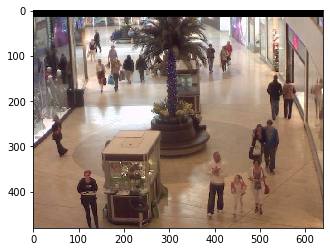

In [3]:
img=plt.imshow(images[200])

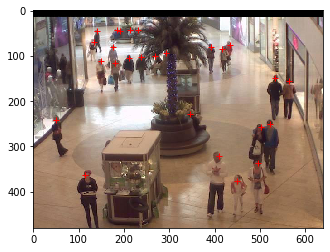

In [4]:
img=plt.imshow(images[200])
img=plt.plot(images_gt[200][:,0],images_gt[200][:,1],'r+')

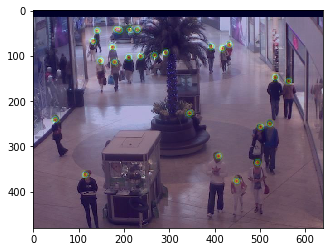

In [5]:
plt.imshow(images[200])
plt.imshow(images_density[200],cmap='gist_ncar',alpha=0.3)

In [6]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPooling2D, concatenate, Input, UpSampling2D, Conv2DTranspose, ReLU, Activation, BatchNormalization
from keras.models import Model
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_percentage_error
from keras.optimizers import Adam, Nadam
import keras.backend as K

Using TensorFlow backend.


In [7]:
def MCCNN(input_shape=(None,None,3)):
    input_flow=Input(input_shape)
    
    x_1=Conv2D(16,9,padding='same',activation='relu')(input_flow)
    x_1=BatchNormalization()(x_1)
    x_1=MaxPooling2D(padding='same')(x_1)
    x_1=Conv2D(32,7,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=MaxPooling2D(padding='same')(x_1)
    x_1=Conv2D(16,7,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(8,7,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=UpSampling2D(size=(2,2))(x_1)
    
    
    x_1=Conv2D(8,5,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    #x_1=UpSampling2D(size=(2,2))(x_1)
    x_1=Conv2DTranspose(8, kernel_size=(2, 2), strides=(2, 2))(x_1)
    x_1=BatchNormalization()(x_1)
    
    x_1=Conv2D(8,5,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    
    
    x_2=Conv2D(20,7,padding='same',activation='relu')(input_flow)
    x_2=BatchNormalization()(x_2)
    x_2=MaxPooling2D(padding='same')(x_2)
    x_2=Conv2D(40,5,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=MaxPooling2D(padding='same')(x_2)
    x_2=Conv2D(20,5,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(10,5,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    
    x_2=UpSampling2D(size=(2,2))(x_2)
    
    x_2=Conv2D(10,3,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    
    
    #x_2=UpSampling2D(size=(2,2))(x_2)
    x_2=Conv2DTranspose(10, kernel_size=(2, 2), strides=(2, 2))(x_2)
    x_2=BatchNormalization()(x_2)
    
    
    x_2=Conv2D(10,3,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    
    
    x_3=Conv2D(24,5,padding='same',activation='relu')(input_flow)
    x_3=BatchNormalization()(x_3)
    x_3=MaxPooling2D(padding='same')(x_3)
    x_3=Conv2D(48,3,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=MaxPooling2D(padding='same')(x_3)
    x_3=Conv2D(24,3,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(12,3,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    
    x_3=UpSampling2D(size=(2,2))(x_3)

    x_3=Conv2D(12,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    
    #x_3=UpSampling2D(size=(2,2))(x_3)
    x_3=Conv2DTranspose(12, kernel_size=(2, 2), strides=(2, 2))(x_3)
    x_3=BatchNormalization()(x_3)
    
    x_3=Conv2D(12,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    
    x=concatenate([x_1,x_2,x_3])
    
    
    x=Conv2D(1,1,padding='same',activation='relu')(x)
    
    
    
    
    
    
    model=Model(inputs=input_flow,outputs=x)    
    
    
    

    return model        

In [8]:
def ssim_loss(y_true, y_pred, c1=0.01**2, c2=0.03**2):
    weights_initial = np.multiply(
        cv2.getGaussianKernel(12, 2),
        cv2.getGaussianKernel(16, 2).T
    )
    weights_initial = weights_initial.reshape(*weights_initial.shape, 1, 1)
    weights_initial = K.cast(weights_initial, tf.float32)

    mu_F = tf.nn.conv2d(y_pred, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_Y = tf.nn.conv2d(y_true, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_F_mu_Y = tf.multiply(mu_F, mu_Y)
    mu_F_squared = tf.multiply(mu_F, mu_F)
    mu_Y_squared = tf.multiply(mu_Y, mu_Y)

    sigma_F_squared = tf.nn.conv2d(tf.multiply(y_pred, y_pred), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_squared
    sigma_Y_squared = tf.nn.conv2d(tf.multiply(y_true, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_Y_squared
    sigma_F_Y = tf.nn.conv2d(tf.multiply(y_pred, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_mu_Y

    ssim = ((2 * mu_F_mu_Y + c1) * (2 * sigma_F_Y + c2)) / ((mu_F_squared + mu_Y_squared + c1) * (sigma_F_squared + sigma_Y_squared + c2))

    return 1 - tf.reduce_mean(ssim, axis=[1, 2, 3])


def ssim_eucli_loss(y_true, y_pred, alpha=0.0025):
    ssim = ssim_loss(y_true, y_pred)
    eucli = mean_squared_error(y_true, y_pred)
    loss = eucli + alpha * ssim
    return loss

def mae_cnt(labels,preds):
    cnt_label=K.sum(labels)
    cnt_pred=K.sum(preds)
    return K.abs(cnt_label-cnt_pred)



In [9]:
lr=1e-5
model=MCCNN()
model.summary()

#load param weight
model.load_weights("MCCNN")

Optimizer=Nadam(lr)
model.compile(optimizer=Optimizer,loss=ssim_eucli_loss,metrics=[mae_cnt])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 3904        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, None, None, 2 2960        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, None, None, 2 1824        input_1[0][0]                    
____________________________________________________________________________________________

In [10]:
X_train, X_val, Y_train, Y_val=train_test_split(images,images_density,test_size=0.2,random_state=42)
Y_train=np.expand_dims(Y_train,-1)
Y_val=np.expand_dims(Y_val,-1)

In [11]:
def get_patch(X,Y):
    size=[120,160]
    x_patch=np.zeros([X.shape[0],size[0],size[1],3])
    y_patch=np.zeros([Y.shape[0],size[0],size[1],1])
    
    for i in range(x_patch.shape[0]):
    
        x1=np.random.randint(0,X.shape[1]-size[0]-1)
        y1=np.random.randint(0,X.shape[2]-size[1]-1)
        x2=size[0]+x1
        y2=size[1]+y1

        x_patch[i]=X[i,x1:x2,y1:y2,:]
        y_patch[i]=Y[i,x1:x2,y1:y2,:]
    
    return x_patch,y_patch

def full_eval(x):
    y=np.zeros([480,640])
    for i in range(0,480,120):
        for j in range(0,640,160):
            y[i:i+120,j:j+160]+=model.predict(x[:,i:i+120,j:j+160,:])[0,:,:,0]
    return y

In [12]:
'''for i in range(20):
    x_patch,y_patch=get_patch(X_train,Y_train)
    x_patch_val,y_patch_val=get_patch(X_val,Y_val)
    
    model.fit(x_patch,y_patch,batch_size=1,epochs=1,validation_data=(x_patch_val,y_patch_val))'''

'for i in range(20):\n    x_patch,y_patch=get_patch(X_train,Y_train)\n    x_patch_val,y_patch_val=get_patch(X_val,Y_val)\n    \n    model.fit(x_patch,y_patch,batch_size=1,epochs=1,validation_data=(x_patch_val,y_patch_val))'

25.573702965889126 24.000000000000007


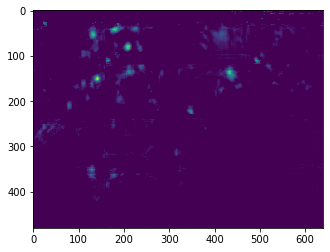

In [13]:
e=8
ex_val=full_eval(X_val[e:e+1])
plt.imshow(ex_val)
print(np.sum(ex_val)/1000,np.sum(Y_val[e:e+1])/1000)



In [14]:
error=0
for i in range(400):
    error+=np.abs((np.sum(full_eval(X_val[i:i+1]))-np.sum(Y_val[i:i+1])))/1000
error


1340.0744316896244

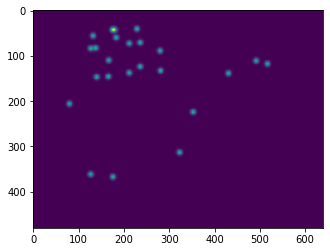

In [15]:
plt.imshow(Y_val[e][:,:,0])

In [16]:
'''model.save_weights("MCCNN") '''

'model.save_weights("MCCNN") '